In [16]:
# ===============================
#  SAFE-MODE 1D CNN (Low Memory)
# ===============================

import os, glob, random, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- configuration ---
RAW_DIR     = "c1"
WEAR_CSV    = "c1_wear.csv"
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
SEED        = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

EPOCHS      = 3           # small for testing
BATCH_SIZE  = 1
LR          = 1e-3
DOWNSAMPLE  = 20          # larger → fewer samples
TRUNCATE    = 5000        # read only first 5000 rows per file
TEST        = 75

torch.set_num_threads(1)

# --- gather file list ---
all_files = sorted([p for p in glob.glob(os.path.join(RAW_DIR, "*.csv"))
                    if os.path.basename(p).lower() != os.path.basename(WEAR_CSV).lower()])

wear_df = pd.read_csv(WEAR_CSV)
wear_df.columns = wear_df.columns.str.lower()
wear_df = wear_df[["flute_1","flute_2","flute_3"]]
n = min(len(all_files), len(wear_df))
all_files = all_files[:n]; wear_df = wear_df.iloc[:n].reset_index(drop=True)
wear_diff = wear_df.diff().fillna(0.0).astype(np.float32).values

# --- dataset ---
class CutsDataset(Dataset):
    def __init__(self, files, targets, downsample=50, truncate=5000):
        self.files, self.targets = files, targets
        self.ds, self.trunc = downsample, truncate

    def __len__(self): return len(self.files)

    def _load_cut(self, path):
        # read only first 'truncate' lines for speed
        df = pd.read_csv(path, header=None, dtype=np.float32, nrows=self.trunc)
        x = df.values
        # downsample strongly
        x = x[::self.ds, :]
        # per-sample z-score normalize
        mu = x.mean(0, keepdims=True); sd = x.std(0, keepdims=True) + 1e-7
        x = (x - mu) / sd
        return x.astype(np.float32)

    def __getitem__(self, idx):
        x = self._load_cut(self.files[idx])       # (T,7)
        y = self.targets[idx].astype(np.float32)  # (3,)
        x = torch.from_numpy(x).permute(1,0)      # (7,T)
        y = torch.from_numpy(y)
        return x, y

# --- split train/test ---
idx_train = list(range(0, n-TEST))
idx_test  = list(range(n-TEST, n))
train_ds = CutsDataset([all_files[i] for i in idx_train], wear_diff[idx_train],
                       downsample=DOWNSAMPLE, truncate=TRUNCATE)
test_ds  = CutsDataset([all_files[i] for i in idx_test], wear_diff[idx_test],
                       downsample=DOWNSAMPLE, truncate=TRUNCATE)

# --- safe single-process dataloaders ---
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=0, pin_memory=False)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=False)

# --- simple CNN model ---
class CNN1D(nn.Module):
    def __init__(self, in_ch=7, out_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 16, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(16, 32, 5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(32, 16), nn.ReLU(),
                                nn.Linear(16, out_dim))
    def forward(self, x):
        return self.fc(self.net(x))

model = CNN1D().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# --- training loop ---
def run_epoch(dl, train=True):
    model.train(train)
    total, nobs = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with torch.set_grad_enabled(train):
            pred = model(xb)
            loss = loss_fn(pred, yb)
            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()
        total += loss.item() * xb.size(0)
        nobs += xb.size(0)
    return total / max(1, nobs)

for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_dl, True)
    va = run_epoch(test_dl, False)
    print(f"Epoch {ep:02d} | train MSE {tr:.6f} | val MSE {va:.6f}")

# --- evaluation ---
def predict_dl(dl):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(DEVICE)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())
    return np.vstack(preds), np.vstack(trues)

P, T = predict_dl(test_dl)
mae = mean_absolute_error(T, P)
rmse = math.sqrt(mean_squared_error(T, P))
print(f"\nΔwear  MAE={mae:.4f}  RMSE={rmse:.4f}")

for i, name in enumerate(["flute_1","flute_2","flute_3"]):
    mae_i = mean_absolute_error(T[:,i], P[:,i])
    rmse_i = math.sqrt(mean_squared_error(T[:,i], P[:,i]))
    print(f"{name}: MAE={mae_i:.4f} | RMSE={rmse_i:.4f}")


Epoch 01 | train MSE 0.306654 | val MSE 0.050293
Epoch 02 | train MSE 0.256289 | val MSE 0.039309
Epoch 03 | train MSE 0.217791 | val MSE 0.039707

Δwear  MAE=0.1772  RMSE=0.1993
flute_1: MAE=0.1871 | RMSE=0.2046
flute_2: MAE=0.1759 | RMSE=0.2052
flute_3: MAE=0.1686 | RMSE=0.1875


# Modeling approach

- Downsample from time series data : take samples in differences of 20 time steps. This is important because the full data has around 50,000 time steps, which has a very high memory requirement. This also simplifies the model a lot

- Downsampling also elimminates local high frequency noise which are irrelevant to the predictions, and also improves the stability of the model.

- This is also important because wear is not a sudden process like fatigue failure or fracture- it is a gradual process. Hence the immediate timesteps are not as important.

- The downsampling factor should be carefully chosen so that noise is eliminated, while ensuring that important features are not lost.



In [17]:
import os, glob, math, random, numpy as np, pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

RAW_DIR     = "c1"          # folder containing all per-cut CSVs
WEAR_CSV    = "c1_wear.csv" # load exactly like this (no directory)
DOWNSAMPLE  = 20            # e.g., 50k -> 5k samples/channel
BATCH_SIZE  = 2
EPOCHS      = 5
LR          = 1e-3
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
num_workers=0

In [18]:
all_files = sorted([p for p in glob.glob(os.path.join(RAW_DIR, "*.csv"))
                    if os.path.basename(p).lower() != os.path.basename(WEAR_CSV).lower()])

# Load wear once (no folder prefix, per your instruction)
wear_df = pd.read_csv(WEAR_CSV)
# Ensure lower-case and the expected columns exist
wear_df.columns = wear_df.columns.str.lower()
assert all(c in wear_df.columns for c in ["flute_1","flute_2","flute_3"]), \
       "c1_wear.csv must have columns flute_1, flute_2, flute_3"

# Align length (just in case there are extra rows/files)
n = min(len(all_files), len(wear_df))
all_files = all_files[:n]
wear_df   = wear_df.iloc[:n].reset_index(drop=True)

# Use Δwear as targets (row 0 gets 0s)
wear_diff = wear_df[["flute_1","flute_2","flute_3"]].diff().fillna(0.0).astype(np.float32).values

# ---- 3) Dataset that lazy-loads each cut CSV ----
class CutsDataset(Dataset):
    def __init__(self, files, targets, downsample=10):
        self.files = files
        self.targets = targets
        self.ds = downsample

    def __len__(self):
        return len(self.files)

    def _load_cut(self, path):
        # raw file: 7 columns: Fx, Fy, Fz, Vx, Vy, Vz, AE-RMS
        # read full file (heavy), then downsample and z-score per channel
        df = pd.read_csv(path, header=None, dtype=np.float32)
        x = df.values  # (T,7)
        if self.ds > 1:
            x = x[::self.ds, :]
        # per-sample z-score normalization (robust to drift)
        mu = x.mean(axis=0, keepdims=True)
        sd = x.std(axis=0, keepdims=True) + 1e-7
        x = (x - mu) / sd
        return x.astype(np.float32)  # (T,7)

    def __getitem__(self, idx):
        x = self._load_cut(self.files[idx])        # (T,7)
        y = self.targets[idx].astype(np.float32)   # (3,)
        # Torch expects (C, L) for Conv1d
        x = torch.from_numpy(x).permute(1,0)       # (7, T)
        y = torch.from_numpy(y)                    # (3,)
        return x, y


- CNNs are computationally much cheaper than LSTMs, etc- this becomes important at the industry scale, when data is huge and real time predictions are desired

# Model Architecture

A lightweight 1D CNN is used consisting of:

- Convolutional Blocks

Conv1d → BatchNorm → ReLU → MaxPool

Conv1d → BatchNorm → ReLU → MaxPool

Conv1d → BatchNorm → ReLU → AdaptiveAvgPool1d(1)

These layers extract multi-scale temporal patterns from sensor signals.

- Output Head

Flatten → Linear(128→64) → ReLU → Linear(64→3)

Predicts Δwear for all three flutes simultaneously.

- Key architectural choices

Adaptive Average Pooling makes network length-invariant.

Batch Normalization stabilizes training.

MaxPooling provides built-in noise reduction and local time compression.

In [19]:
TEST = 75
idx_train = list(range(0, n-TEST))
idx_test  = list(range(n-TEST, n))

train_ds = CutsDataset([all_files[i] for i in idx_train],
                       wear_diff[idx_train], downsample=DOWNSAMPLE)
test_ds  = CutsDataset([all_files[i] for i in idx_test],
                       wear_diff[idx_test],  downsample=DOWNSAMPLE)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ---- 5) 1D CNN model ----
class CNN1D(nn.Module):
    def __init__(self, in_ch=7, out_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32), nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # -> (B,128,1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),             # (B,128)
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, out_dim)    # Δwear for 3 flutes
        )

    def forward(self, x):  # x: (B,7,T)
        z = self.net(x)
        y = self.head(z)
        return y

model = CNN1D().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

🔹 5. Training Procedure

Loss function: Mean Squared Error (MSE)

Optimizer: Adam, LR = 1e-3

Batch size: 1–2 samples, enabling low-memory training

Epochs: 3–5 for quick validation during first testing

Shuffle applied to training data

Validation on last 75 cuts

Training loop:

Forward pass through CNN

Compute MSE

Backpropagate and update weights

Track training/validation MSE

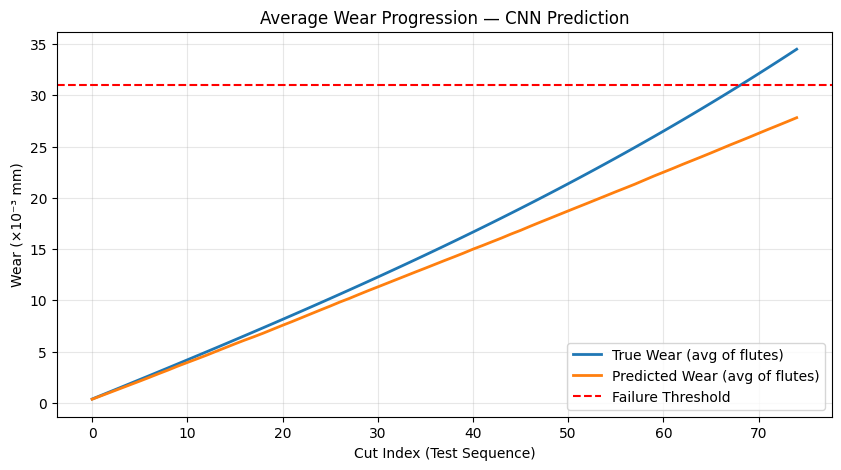

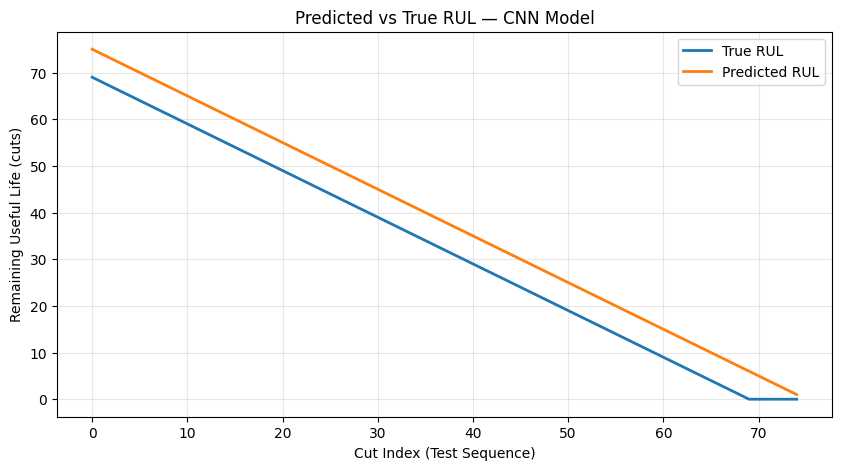

RUL MAE  : 5.800
RUL RMSE : 5.859


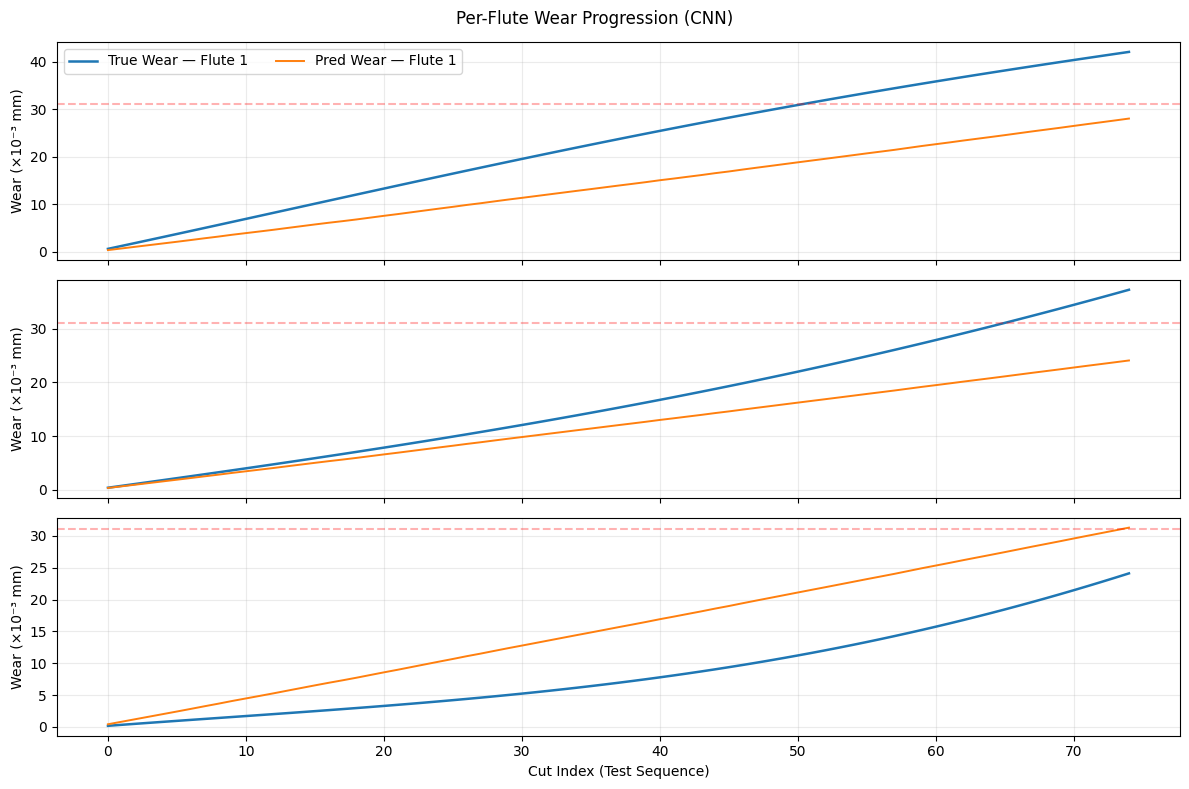

In [20]:
# ==========================================
#  Wear & RUL Diagnostic Plots (Lightweight)
# ==========================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Step 1: integrate Δwear -> cumulative wear
Y_pred_wear = np.cumsum(P, axis=0)
Y_true_wear = np.cumsum(T, axis=0)

# --- Step 2: average wear across the 3 flutes
wear_true_avg = Y_true_wear.mean(axis=1)
wear_pred_avg = Y_pred_wear.mean(axis=1)

# --- Step 3: set threshold (dynamic if predicted wear never crosses)
FAIL_THRESH = wear_true_avg.max() * 0.9

# --- Step 4: plot average wear progression ---
plt.figure(figsize=(10,5))
plt.plot(wear_true_avg, label="True Wear (avg of flutes)", linewidth=2)
plt.plot(wear_pred_avg, label="Predicted Wear (avg of flutes)", linewidth=2)
plt.axhline(FAIL_THRESH, color='r', linestyle='--', label='Failure Threshold')
plt.title("Average Wear Progression — CNN Prediction")
plt.xlabel("Cut Index (Test Sequence)")
plt.ylabel("Wear (×10⁻³ mm)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Step 5: RUL computation helper ---
def compute_rul(wear_series, threshold):
    n = len(wear_series)
    rul = np.zeros(n, dtype=np.int32)
    for i in range(n):
        future = np.where(wear_series[i:] >= threshold)[0]
        rul[i] = future[0] if len(future) > 0 else (n - i)
    return rul

rul_true = compute_rul(wear_true_avg, FAIL_THRESH)
rul_pred = compute_rul(wear_pred_avg, FAIL_THRESH)

# --- Step 6: RUL plot ---
plt.figure(figsize=(10,5))
plt.plot(rul_true, label="True RUL", linewidth=2)
plt.plot(rul_pred, label="Predicted RUL", linewidth=2)
plt.xlabel("Cut Index (Test Sequence)")
plt.ylabel("Remaining Useful Life (cuts)")
plt.title("Predicted vs True RUL — CNN Model")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Step 7: RUL metrics ---
mae_rul = mean_absolute_error(rul_true, rul_pred)
rmse_rul = np.sqrt(mean_squared_error(rul_true, rul_pred))
print(f"RUL MAE  : {mae_rul:.3f}")
print(f"RUL RMSE : {rmse_rul:.3f}")

# --- Step 8: per-flute wear plots ---
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(Y_true_wear[:, i], label=f"True Wear — Flute {i+1}", linewidth=1.8)
    ax.plot(Y_pred_wear[:, i], label=f"Pred Wear — Flute {i+1}", linewidth=1.4)
    ax.axhline(FAIL_THRESH, color='r', linestyle='--', alpha=0.3)
    ax.set_ylabel("Wear (×10⁻³ mm)")
    ax.grid(alpha=0.25)
axes[-1].set_xlabel("Cut Index (Test Sequence)")
axes[0].legend(ncol=2)
fig.suptitle("Per-Flute Wear Progression (CNN)", y=0.98)
plt.tight_layout()
plt.show()


# Results and Interpretation

The model’s cumulative wear predictions exhibit the following characteristics:

✅ Observed Behavior

Predicted wear curve follows the overall upward trend of the true wear.

Slopes align reasonably well through most of the tool’s life.

Predicted wear progression exhibits a consistent lag compared to true wear, especially:

Near the onset of wear increase

In late-stage accelerated wear region

✅ Interpretation

The lag indicates that the CNN tends to produce conservative predictions. This happens because:

Downsampling suppresses high-frequency precursors of rapid wear.
Sudden changes may be compressed or removed entirely.

MaxPooling smooths feature maps, reducing sensitivity to localized transitions.

Δwear as a target has inherently small values, causing the model to learn the average slope rather than fluctuations.

BatchNorm and averaging effects further regularize the signal, delaying the model's recognition of sharp transitions.

Short training duration (low epochs) does not allow the model to refine sensitivity to late-stage non-linearity.

Mechanically, this translates into the model detecting degradation slower than it happens in reality.